# Project Sections



1.   Data Collection
2.   Business understanding
3.   Data Annotation
4.   EDA Lifecyle
5.   Model experiments/improvement (Python code)


**Data Collection:**

Data is collected as threads of e-mail in a json file. Source of data - email.

**Meta data understanding**

Thread contains Message and each message contains Message ID, sender, date, subject, receiver, text_body.

**Business understanding:**

  The scope of the problem is limited to classify the email as legitimate real estate email or spam.

**Data Annotation**
Each thread is annotated as spam or non spam. Spam is denoted by 1, non spam is denoted by 0.

  








## Install required packages

In [1]:
!pip install datasets --quiet
!pip install mimesis --quiet
!pip install nltk --quiet
!pip install wordcloud --quiet
!pip install mlflow --quiet
!pip install pyLDAvis --quiet
!pip install gensim --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import all the necessary library

In [56]:
import os
import csv
import json
import random
import string
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
import pyLDAvis.gensim_models

from datasets import load_dataset
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_numeric, strip_short
import mlflow


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Folder path which contains dataset

In [5]:
# Replace the path with your folder path
max_h_path = "drive/MyDrive/max_homes"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Path of inbox data and labels data

In [6]:
email_inbox_data_path = os.path.join(max_h_path,"email_inbox_data.json")
email_ham_spam_path = os.path.join(max_h_path,"email_ham_spam.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load the inbox data as json

In [7]:
with open(email_inbox_data_path) as json_file:
  email_data = json.load(json_file)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
len(list(email_data.keys()))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1000

In [9]:
email_threads_dict = email_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Convert the json to dataframe

In [57]:
# Convert the dictionary to a DataFrame
email_threads_df = pd.DataFrame.from_dict({(i, j): email_threads_dict[i][j]
                                           for i in email_threads_dict.keys()
                                           for j in email_threads_dict[i].keys()},
                                          orient='index')

# Reset index to separate the multi-level index into separate columns
email_threads_df.reset_index(inplace=True)
email_threads_df.drop(columns=['level_1'], inplace=True)
email_threads_df.rename(columns={'level_0': 'thread_id'}, inplace=True)

# # Load CSV file containing thread_id and is_spam information
spam_info_df = pd.read_csv(email_ham_spam_path,index_col=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Display sample data of labels csv file

In [11]:
spam_info_df.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,thread_id,is_spam
0,18e539bdc6872155,0
1,18eaf8220475471a,1


### Num spam vs ham email threads

In [12]:
spam_info_df['is_spam'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


is_spam
1    800
0    200
Name: count, dtype: int64

In [13]:
df = email_threads_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Analysis on threads and their message count

In [53]:
message_count_per_thread = df['thread_id'].value_counts()
message_count_per_thread_df = message_count_per_thread.reset_index()
message_count_per_thread_df.columns = ['thread_id', 'message_count']
message_count_per_thread_df.head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,thread_id,message_count
0,18eaa95659e46ced,10
1,18db381d2257822d,10
2,18ee3711066442c6,9
3,18da2d3871e15e8b,9
4,18ecf4dbc862dbed,9
5,18d574676c555b09,9
6,18d47b90f85f66b7,8
7,18ecde24026659c1,8
8,18ecf27cc3e6f4a9,8
9,18e10ac043947d39,7


### Plots for message counts distribution

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


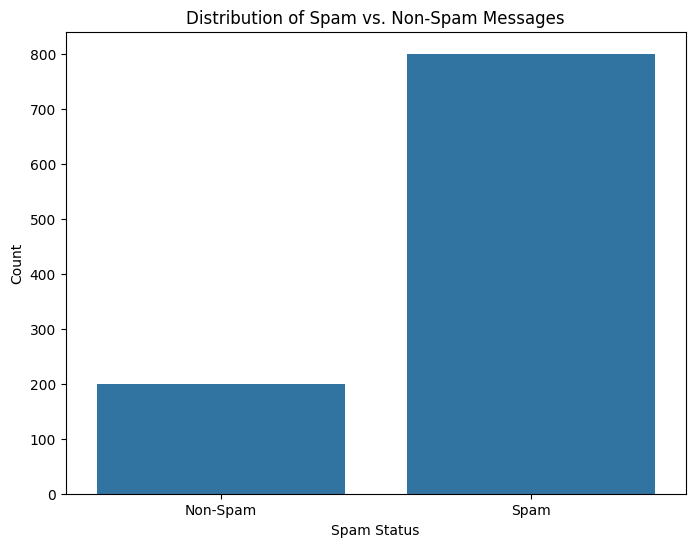

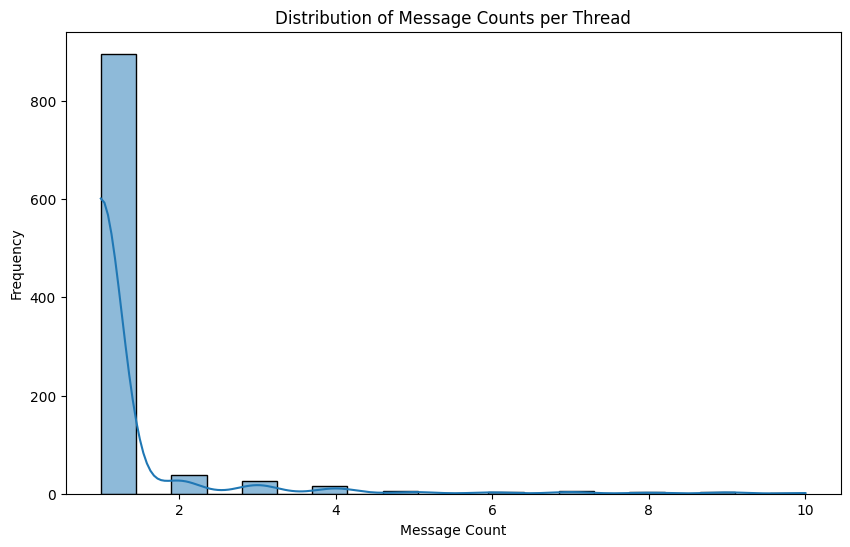

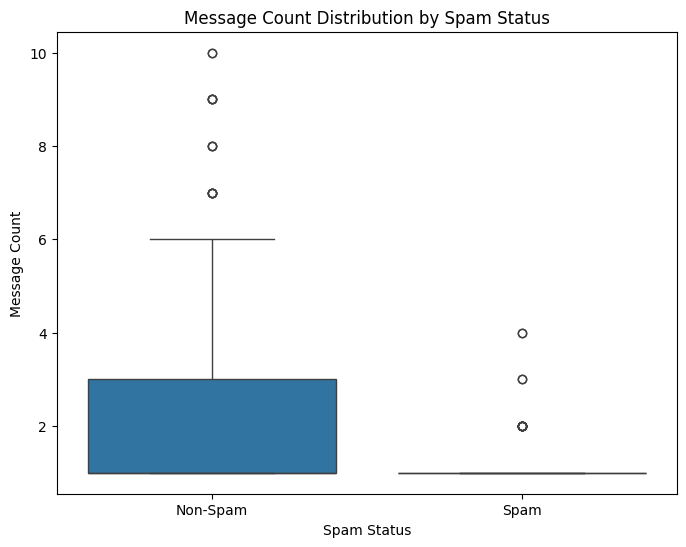

In [15]:
# Plot 1: Bar Plot for Spam vs. Non-Spam Messages
plt.figure(figsize=(8, 6))
sns.countplot(x='is_spam', data=spam_info_df)
plt.title('Distribution of Spam vs. Non-Spam Messages')
plt.xlabel('Spam Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Spam', 'Spam'])
plt.show()

# Plot 2: Histogram for Message Count Distribution
plt.figure(figsize=(10, 6))
sns.histplot(x='message_count', data=message_count_per_thread_df, bins=20, kde=True)
plt.title('Distribution of Message Counts per Thread')
plt.xlabel('Message Count')
plt.ylabel('Frequency')
plt.show()

# Merge the DataFrames on 'thread_id'
merged_df = pd.merge(spam_info_df, message_count_per_thread_df, on='thread_id')

# Plot 3: Box Plot for Message Count by Spam Status
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_spam', y='message_count', data=merged_df)
plt.title('Message Count Distribution by Spam Status')
plt.xlabel('Spam Status')
plt.ylabel('Message Count')
plt.xticks([0, 1], ['Non-Spam', 'Spam'])
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


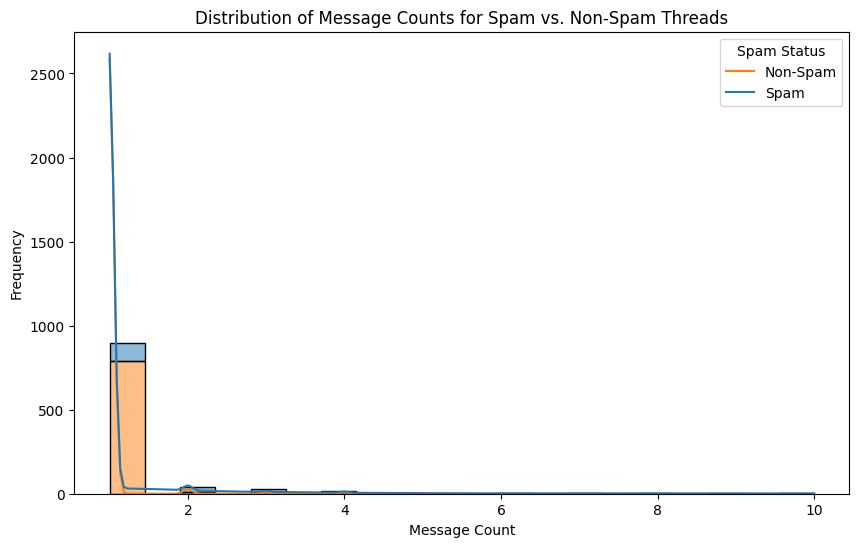

In [16]:
# Plot Distribution of Message Counts for Spam vs. Non-Spam Threads
plt.figure(figsize=(10, 6))
sns.histplot(x='message_count', data=merged_df, bins=20, kde=True, hue='is_spam', multiple='stack')
plt.title('Distribution of Message Counts for Spam vs. Non-Spam Threads')
plt.xlabel('Message Count')
plt.ylabel('Frequency')
plt.legend(title='Spam Status', labels=['Non-Spam', 'Spam'])
plt.show()

In [17]:
# Calculate distribution of message counts for spam vs. non-spam threads
spam_message_count = merged_df[merged_df['is_spam'] == 1]['message_count'].value_counts().sort_index()
non_spam_message_count = merged_df[merged_df['is_spam'] == 0]['message_count'].value_counts().sort_index()

# Print the distribution
print("Distribution of Message Counts for Spam Threads:")
print(spam_message_count)
print("\nDistribution of Message Counts for Non-Spam Threads:")
print(non_spam_message_count)


Distribution of Message Counts for Spam Threads:
message_count
1    787
2      9
3      2
4      2
Name: count, dtype: int64

Distribution of Message Counts for Non-Spam Threads:
message_count
1     109
2      30
3      24
4      14
5       5
6       4
7       5
8       3
9       4
10      2
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Distribution of Message Counts for Spam vs. Non-Spam Threads

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


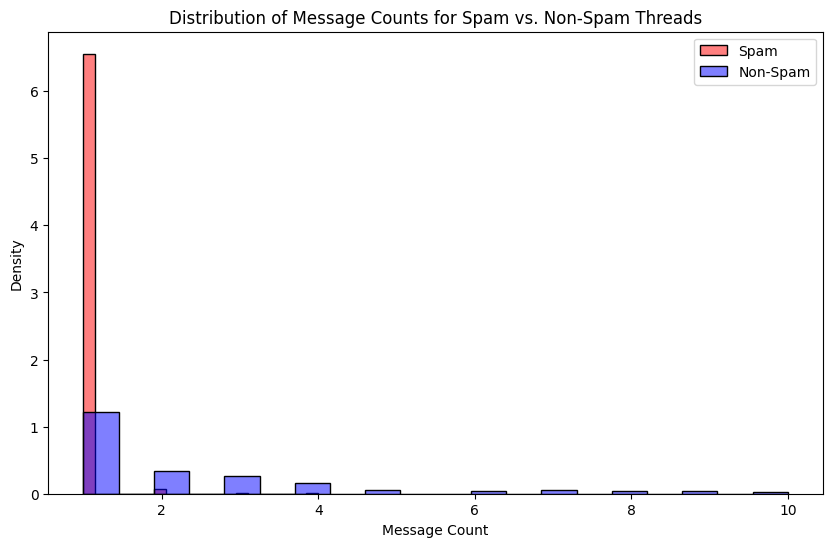

In [18]:
# Filter the DataFrame for spam and non-spam threads
spam_df = merged_df[merged_df['is_spam'] == 1]
non_spam_df = merged_df[merged_df['is_spam'] == 0]

# Plot Distribution of Message Counts for Spam vs. Non-Spam Threads
plt.figure(figsize=(10, 6))

# Plot histogram for spam threads
sns.histplot(x='message_count', data=spam_df, bins=20, color='red', alpha=0.5, label='Spam', stat='density')

# Plot histogram for non-spam threads
sns.histplot(x='message_count', data=non_spam_df, bins=20, color='blue', alpha=0.5, label='Non-Spam', stat='density')

plt.title('Distribution of Message Counts for Spam vs. Non-Spam Threads')
plt.xlabel('Message Count')
plt.ylabel('Density')
plt.legend()
plt.show()


### Merge both the labels and email data as single dataframe

In [19]:
# Merge the two DataFrames based on the 'thread_id' column
email_df = email_threads_df.merge(spam_info_df, on='thread_id', how='inner')

# Print the length of the merged DataFrame
print("Length of the merged DataFrame:", len(email_df))

email_df.head(5)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Length of the merged DataFrame: 1280


,thread_id,messageId,sender,date,subject,receiver,plain_text_body,is_spam
0,18eee096b201e4b5,18ef0c3d8d5f61ae,Tyler Burlison <tyler@tylerburlisonrealestate....,2024-04-18 05:32:18-05:00,Re: 16056 Haven Offer,Larry Schneider <larry@jasonmitchellgroup.com>,"Received. Thank you, On Wed, Apr 17, 2024 at...",0
1,18eee096b201e4b5,18eee4dd01a5d191,Larry Schneider <larry@jasonmitchellgroup.com>,2024-04-17 18:04:19-05:00,Fwd: 16056 Haven Offer,Tyler.Burlison@exprealty.com,"See below, ---------- Forwarded message -----...",0
2,18eee096b201e4b5,18eee18dac3ed949,Larry Schneider <larry@jasonmitchellgroup.com>,2024-04-17 17:06:29-05:00,16056 Haven Offer,Tyler Burlison <tyler@tylerburlisonrealestate....,"Hi Tyler, Please see the attached 7.0 Contra...",0
3,18eef5d36cd1a526,18eef5d36cd1a526,Redfin <redmail@redfin.com>,2024-04-18 04:00:46+00:00,Golden Corridor Market Update: $364K average s...,larry@jasonmitchellgroup.com,What you need to know about the market in Gold...,1
4,18eeeca5919b08e1,18eeeca5919b08e1,LinkedIn <notifications-noreply@linkedin.com>,2024-04-18 01:20:20+00:00,"📩 Larry Schneider, you have a new message and...",Larry Schneider <Larry@jasonmitchellgroup.com>,You have 1 new message View messages:https://w...,1


In [20]:
email_df.describe(include='all')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,thread_id,messageId,sender,date,subject,receiver,plain_text_body,is_spam
count,1280,1280,1280,1280,1280,1280,1280,1280.000000
unique,1000,1280,261,1279,889,169,1261,NaN
top,18eaa95659e46ced,18ef0c3d8d5f61ae,Redfin <listings@redfin.com>,2024-03-08 22:17:20+00:00,"| Destin, FL - most viewed listings of the day |",larry@jasonmitchellgroup.com,,NaN
freq,10,1,161,2,70,541,18,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.639844
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.480233
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [21]:
email_df.groupby('thread_id').describe(include='all')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


messageId                                                    \
                     count unique               top freq mean  std  min  25%   
thread_id                                                                      
18d1f143bc9eb107         1      1  18d1f143bc9eb107    1  NaN  NaN  NaN  NaN   
18d2003b1455f2aa         1      1  18d2003b1455f2aa    1  NaN  NaN  NaN  NaN   
18d238957a00c009         1      1  18d238957a00c009    1  NaN  NaN  NaN  NaN   
18d23ca8ad12a142         1      1  18d23ca8ad12a142    1  NaN  NaN  NaN  NaN   
18d2409dd09f6797         1      1  18d2409dd09f6797    1  NaN  NaN  NaN  NaN   
...                    ...    ...               ...  ...  ...  ...  ...  ...   
18eee104602453c3         1      1  18eee104602453c3    1  NaN  NaN  NaN  NaN   
18eee4935abb610d         1      1  18eee4935abb610d    1  NaN  NaN  NaN  NaN   
18eee8842aa3d8fd         1      1  18eee8842aa3d8fd    1  NaN  NaN  NaN  NaN   
18eeeca5919b08e1         1      1  18eeeca5919b08e1    1  NaN  NaN  NaN  NaN   
18eef5d36cd1a526         1      1  18eef5d36cd1a526    1  NaN  NaN  NaN  NaN   

                            ... is_spam                                        \
                  50%  75%  ...  unique top freq mean std  min  25%  50%  75%   
thread_id                   ...                                                 
18d1f143bc9eb107  NaN  NaN  ...     NaN NaN  NaN  1.0 NaN  1.0  1.0  1.0  1.0   
18d2003b1455f2aa  NaN  NaN  ...     NaN NaN  NaN  1.0 NaN  1.0  1.0  1.0  1.0   
18d238957a00c009  NaN  NaN  ...     NaN NaN  NaN  1.0 NaN  1.0  1.0  1.0  1.0   
18d23ca8ad12a142  NaN  NaN  ...     NaN NaN  NaN  1.0 NaN  1.0  1.0  1.0  1.0   
18d2409dd09f6797  NaN  NaN  ...     NaN NaN  NaN  1.0 NaN  1.0  1.0  1.0  1.0   
...               ...  ...  ...     ...  ..  ...  ...  ..  ...  ...  ...  ...   
18eee104602453c3  NaN  NaN  ...     NaN NaN  NaN  1.0 NaN  1.0  1.0  1.0  1.0   
18eee4935abb610d  NaN  NaN  ...     NaN NaN  NaN  0.0 NaN  0.0  0.0  0.0  0.0   
18eee8842aa3d8fd  NaN  NaN  ...     NaN NaN  NaN  1.0 NaN  1.0  1.0  1.0  1.0   
18eeeca5919b08e1  NaN  NaN  ...     NaN NaN  NaN  1.0 NaN  1.0  1.0  1.0  1.0   
18eef5d36cd1a526  NaN  NaN  ...     NaN NaN  NaN  1.0 NaN  1.0  1.0  1.0  1.0   

                       
                  max  
thread_id              
18d1f143bc9eb107  1.0  
18d2003b1455f2aa  1.0  
18d238957a00c009  1.0  
18d23ca8ad12a142  1.0  
18d2409dd09f6797  1.0  
...               ...  
18eee104602453c3  1.0  
18eee4935abb610d  0.0  
18eee8842aa3d8fd  1.0  
18eeeca5919b08e1  1.0  
18eef5d36cd1a526  1.0  

[1000 rows x 77 columns]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


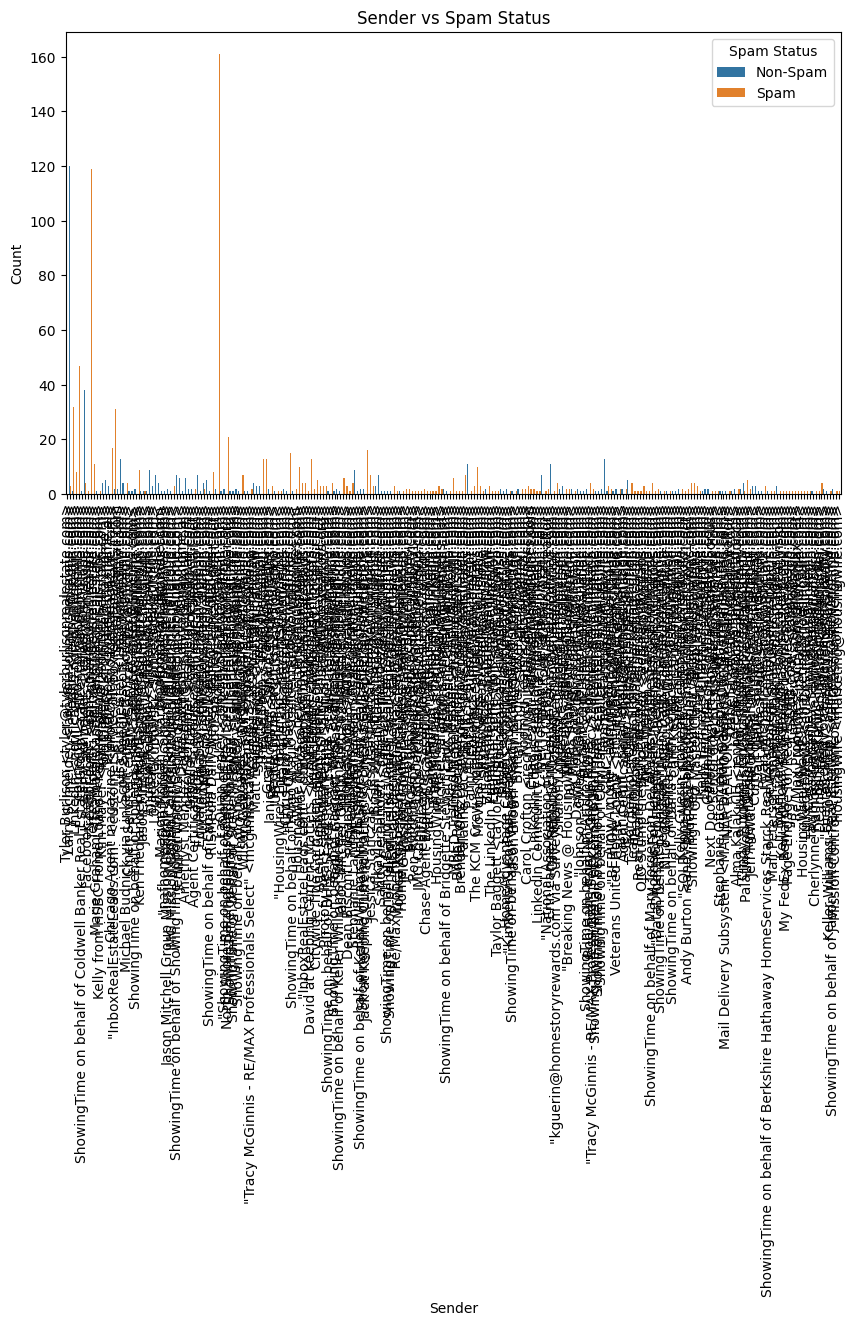

In [25]:
# EDA for sender vs is_spam
plt.figure(figsize=(10, 6))
sns.countplot(x='sender', hue='is_spam', data=email_df)
plt.title('Sender vs Spam Status')
plt.xlabel('Sender')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend(title='Spam Status', labels=['Non-Spam', 'Spam'])
plt.show()

### Sample block to view num of threads a sender is involved

In [22]:
# Assuming 'desired_sender_id' is the sender ID you want to filter for
desired_sender_id = "Larry Schneider <larry@jasonmitchellgroup.com>"

# Filter the DataFrame for the desired sender ID
sender_specific_df = email_df[email_df['sender'] == desired_sender_id]

# Extract the thread IDs and spam status from the filtered DataFrame
thread_ids = sender_specific_df['thread_id'].unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Stats of the sender

In [23]:
# Group by sender and spam status, then aggregate counts
sender_stats = email_df.groupby(['sender', 'is_spam']).size().unstack(fill_value=0)

# Reset index to make 'sender' a regular column
sender_stats.reset_index(inplace=True)

# Rename columns for clarity
sender_stats.columns = ['sender', 'num_non_spam', 'num_spam']

# Calculate total count for each sender
sender_stats['total_count'] = sender_stats['num_spam'] + sender_stats['num_non_spam']

# Sort DataFrame by total_count in descending order
sender_stats.sort_values(by='total_count', ascending=False, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
sender_stats

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,sender,num_non_spam,num_spam,total_count
189,Redfin <listings@redfin.com>,0,161,161
139,Larry Schneider <larry@jasonmitchellgroup.com>,120,3,123
31,"""realtor.com"" <consumer@e.mail.realtor.com>",0,119,119
255,connectMLS <no-reply@connectmls.com>,0,47,47
140,Larry Schneider <noreply@skyslope.com>,38,4,42
...,...,...,...,...
75,Chicago Title <noreply@inhere.com>,1,0,1
163,Matt at Showami <mattkuchar@showami.com>,0,1,1
76,Chris Herb <cherb@jasonmitchellgroup.com>,1,0,1
161,Marlo Parrish <kparrish@firstam.com>,0,1,1


In [25]:
# Convert the 'date' column to pandas datetime format
email_df['date'] = pd.to_datetime(email_df['date'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Analysis on number of emails per thread

In [26]:
# Calculate the number of emails per thread
emails_per_thread = email_df.groupby('thread_id').size()

# Calculate the duration of each email thread
thread_duration = email_df.groupby('thread_id')['date'].apply(lambda x: x.max() - x.min())

# Display summary statistics and visualizations for emails per thread
print("Summary statistics for number of emails per thread:")
emails_per_thread.describe()


# print(thread_duration.describe())


Summary statistics for number of emails per thread:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


count    1000.000000
mean        1.280000
std         1.065239
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        10.000000
dtype: float64

## Analysis on duration of thread open

In [27]:
# # Display summary statistics and visualizations for duration of email threads
print("\nSummary statistics for duration of email threads:")
thread_duration.describe()


Summary statistics for duration of email threads:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


count                         1000
mean        0 days 04:52:26.873000
std      1 days 16:54:18.920229757
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                0 days 00:00:00
max               38 days 19:57:39
Name: date, dtype: object

## Plot for e-mail per thread and duration of threads

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


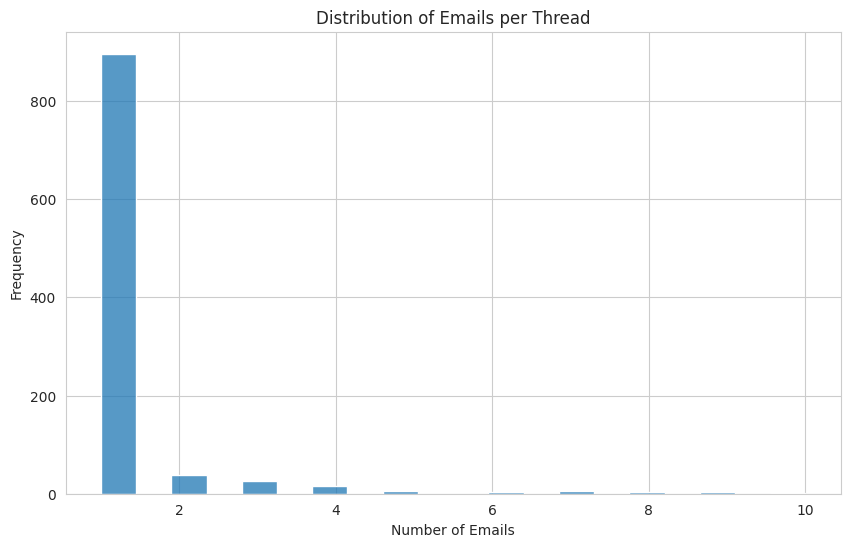

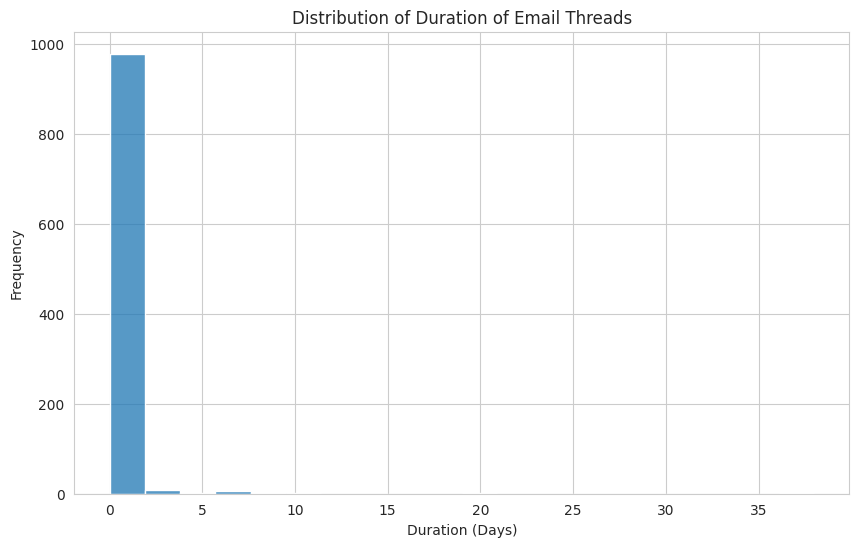

In [28]:
# Set the style for seaborn plots
sns.set_style("whitegrid")

# Plot distribution of emails per thread
plt.figure(figsize=(10, 6))
sns.histplot(emails_per_thread, bins=20, kde=False)
plt.title('Distribution of Emails per Thread')
plt.xlabel('Number of Emails')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of duration of email threads
plt.figure(figsize=(10, 6))
sns.histplot(thread_duration.dt.days, bins=20, kde=False)
plt.title('Distribution of Duration of Email Threads')
plt.xlabel('Duration (Days)')
plt.ylabel('Frequency')
plt.show()

## Interactive plot of number of email

In [29]:
emails_per_thread_df = emails_per_thread.reset_index()
emails_per_thread_df.columns = ['thread_id', 'num_emails']
# Plot distribution of emails per thread
fig1 = px.histogram(emails_per_thread_df, x='num_emails', title='Distribution of Emails per Thread',
                    labels={'num_emails': 'Number of Emails'}, nbins=20)
fig1.update_layout(xaxis_title='Number of Emails', yaxis_title='Frequency')
fig1.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Analysis on Number of Messages per Day

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



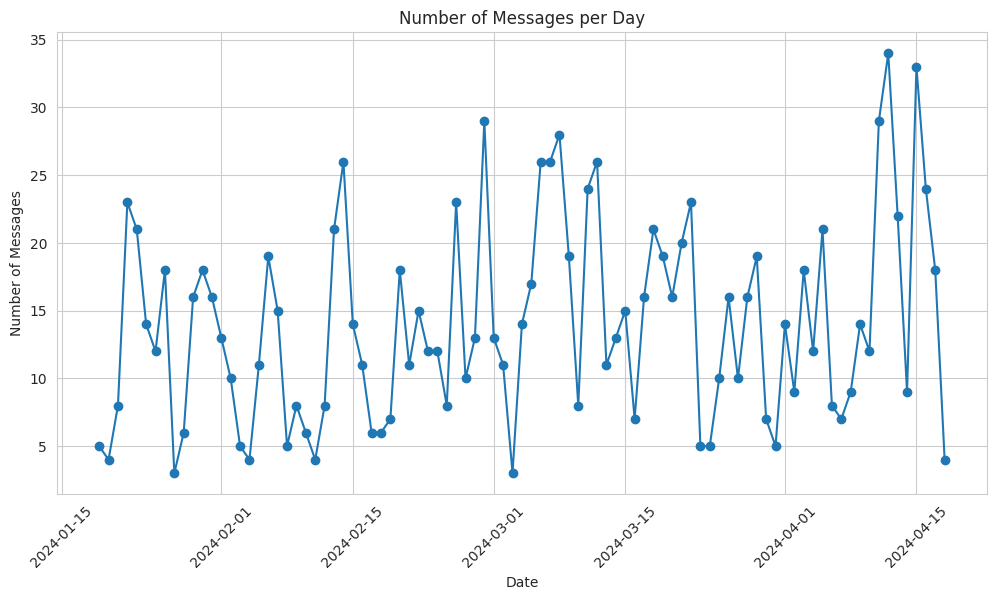

In [30]:
# Create a copy of the DataFrame to avoid modifying the original
email_df_copy = email_df.copy()

# Convert 'date' column to pandas datetime format and remove time zone information
email_df_copy['date'] = pd.to_datetime(email_df_copy['date'], utc=True).dt.tz_localize(None)

# Extract date from the datetime object
email_df_copy['date'] = email_df_copy['date'].dt.date

# Group by date and count the number of messages for each day
messages_per_day = email_df_copy.groupby('date').size()

# Plot
plt.figure(figsize=(12, 6))
messages_per_day.plot(kind='line', marker='o', linestyle='-')
plt.title('Number of Messages per Day')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [31]:
# Group by date and count the number of messages for each day
messages_per_day = email_df_copy.groupby('date').size()

# Create a DataFrame with date and number of messages columns
messages_per_day_df = pd.DataFrame({'date': messages_per_day.index, 'num_messages': messages_per_day.values})
# Sort the DataFrame by the 'date' column
messages_per_day_df_sorted = messages_per_day_df.sort_values(by='num_messages')
print("DataFrame with Date and Number of Messages:")
messages_per_day_df_sorted

DataFrame with Date and Number of Messages:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,date,num_messages
44,2024-03-03,3
8,2024-01-27,3
90,2024-04-18,4
1,2024-01-20,4
23,2024-02-11,4
...,...,...
49,2024-03-08,28
41,2024-02-29,29
83,2024-04-11,29
87,2024-04-15,33


In [32]:


# Group by date and count the number of messages for each day
messages_per_day = email_df_copy.groupby('date').size().reset_index(name='num_messages')

# Create an interactive line plot with hover information
fig = px.line(messages_per_day, x='date', y='num_messages', title='Number of Messages per Day')
fig.update_traces(mode='lines+markers', hovertemplate='Date: %{x}<br>Number of Messages: %{y}')
fig.update_xaxes(title='Date', tickangle=45)
fig.update_yaxes(title='Number of Messages')
fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Dataframe of thread duration, start,end date

In [33]:
# Group by thread_id
thread_groups = email_df.groupby('thread_id')

# Initialize lists to store data
thread_ids = []
start_dates = []
end_dates = []
is_spam_list = []
num_days_list = []

# Iterate over each thread group
for thread_id, group in thread_groups:
    # Calculate start and end dates
    start_date = group['date'].min()
    end_date = group['date'].max()

    # Calculate is_spam (assume all emails in the thread have the same spam status)
    is_spam = group['is_spam'].iloc[0]

    # Calculate number of days
    num_days = (end_date - start_date).days

    # Append data to lists
    thread_ids.append(thread_id)
    start_dates.append(start_date)
    end_dates.append(end_date)
    is_spam_list.append(is_spam)
    num_days_list.append(num_days)

# Create DataFrame
thread_summary_df = pd.DataFrame({
    'thread_id': thread_ids,
    'start_date': start_dates,
    'end_date': end_dates,
    'is_spam': is_spam_list,
    'num_days': num_days_list
})

# Sort the DataFrame by num_days
thread_summary_df = thread_summary_df.sort_values(by='num_days', ascending=False)

# Display the sorted DataFrame
thread_summary_df


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,thread_id,start_date,end_date,is_spam,num_days
315,18dc8c61e3d86514,2024-02-20 17:12:55-06:00,2024-03-30 14:10:34-05:00,0,38
246,18da89735a2c5a19,2024-02-14 17:08:13+00:00,2024-03-05 18:07:21+00:00,0,20
83,18d47b90f85f66b7,2024-01-26 21:41:57+00:00,2024-02-14 16:42:29-06:00,0,19
849,18eaa95659e46ced,2024-04-04 19:28:09+00:00,2024-04-15 22:06:38+00:00,0,11
278,18db381d2257822d,2024-02-16 20:00:38+00:00,2024-02-26 19:52:45+00:00,0,9
...,...,...,...,...,...
342,18dd3ed20dcac9b4,2024-02-23 03:05:48+00:00,2024-02-23 03:05:48+00:00,1,0
343,18dd657dfce17fe8,2024-02-23 08:21:38-06:00,2024-02-23 08:21:38-06:00,1,0
344,18dd667fb43fb6a2,2024-02-23 14:39:14+00:00,2024-02-23 14:39:14+00:00,1,0
345,18dd6b2c29bad049,2024-02-23 16:00:55+00:00,2024-02-23 16:00:55+00:00,1,0


In [40]:
# @title
import pandas as pd

# Step 1: Data Preparation and Cleaning

inbox_df = email_df.copy()
# Filter relevant columns
inbox_df = inbox_df[['plain_text_body', 'subject', 'is_spam']]

# Handle missing values
inbox_df.dropna(subset=['plain_text_body', 'subject'], inplace=True)

# Remove spam emails
inbox_df = inbox_df[inbox_df['is_spam'] == False]

# Step 2: Text Processing
# Text normalization, tokenization, and stopwords removal
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    return ' '.join(tokens)

# Remove spam emails
inbox_df['processed_text'] = inbox_df['plain_text_body'].apply(preprocess_text)

# Step 3: Identifying Relevant Emails
# Keywords for real estate transactions
keywords = ['property', 'real estate', 'house', 'buy', 'sell', 'rent', 'lease', 'mortgage', 'appraisal']

# Filter emails containing real estate keywords
inbox_df['is_real_estate'] = inbox_df['processed_text'].apply(lambda x: any(keyword in x for keyword in keywords))
real_estate_emails = inbox_df[inbox_df['is_real_estate']]

# Step 4: Analyzing Topics Among Real Estate Emails
# Topic Modeling
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(real_estate_emails['processed_text'])
lda = LatentDirichletAllocation(n_components=5)  # Assuming we aim to find 5 topics
lda.fit(dtm)

# Display top topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic 0:
loan email veterans united instructions office wire information home sent
Topic 1:
larry pm wrote image email thank message larryjasonmitchellgroupcom il schneider
Topic 2:
td tr px table div solid width valigntop tbody sansserif
Topic 3:
email link documents sender document sent larry contact completed view
Topic 4:
image wrote thank real email estate larry message pm apr


## Emails that are referring to a specific real estate transaction

In [34]:
from sklearn.decomposition import NMF
inbox_df = email_df.copy()
# Define the keywords related to real estate transactions
real_estate_keywords = ["property", "buy", "sell", "rent", "listing", "house", "apartment",
                        "transaction","escrow", "attorney", "inspection", "appraisal","mortgage",
                        "loan", "financing", "down payment","purchase", "offer", "contract", "closing"]

# Function to check if an email is related to real estate transaction
def is_real_estate_transaction(email):
    email_text = email['plain_text_body'].lower() + email['subject'].lower()
    for keyword in real_estate_keywords:
        if keyword in email_text:
            return True
    return False

# Filter emails related to real estate transactions
real_estate_emails = inbox_df[inbox_df.apply(is_real_estate_transaction, axis=1)]

# Extract top topics from real estate emails
corpus = real_estate_emails['subject'].tolist() + real_estate_emails['plain_text_body'].tolist()

# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(corpus)

# Apply Non-negative Matrix Factorization (NMF) for topic modeling
nmf_model = NMF(n_components=5, random_state=42)
topics = nmf_model.fit_transform(tfidf)

# Get the top topics
top_topics = []
for idx, topic in enumerate(nmf_model.components_):
    top_topic_idx = topic.argsort()[-3:][::-1]
    top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_topic_idx]
    top_topics.append(f"Topic {idx+1}: {' '.join(top_words)}")

print(f"Number of emails referring to real estate transaction: {len(real_estate_emails)}")
print("Top topics in real estate emails:")
for topic in top_topics:
    print(topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of emails referring to real estate transaction: 1077
Top topics in real estate emails:
Topic 1: redfin myredfin riftinfo
Topic 2: td style tr
Topic 3: com https larry
Topic 4: destin fl day
Topic 5: home updates update


## Top topics on real estate transaction

In [35]:
import re
import pandas as pd
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_numeric, strip_short
import pyLDAvis.gensim_models
from bs4 import BeautifulSoup  # Import BeautifulSoup

# # Load the email_df DataFrame
inbox_df = email_df.copy()

# Function to remove HTML tags from text
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Function to remove hyperlinks from text
def remove_hyperlinks(text):
    return re.sub(r'http\S+', '', text)
# Additional preprocessing function for HTML tags and email IDs
def preprocess_text_with_html(text):
    text = remove_html_tags(text)
    text = remove_hyperlinks(text)
    # Remove HTML tags
    text_no_html = strip_tags(text)
    # Remove email addresses
    text_no_emails = re.sub(r'\S*@\S*\s?', '', text_no_html)
    return text_no_emails

# Preprocess text data
def preprocess_text(text):
    # Additional preprocessing for HTML and emails
    text = preprocess_text_with_html(text)
    # Tokenize and preprocess text
    tokens = preprocess_string(text)
    # Further preprocessing steps
    tokens = [strip_punctuation(token) for token in tokens]
    tokens = [strip_numeric(token) for token in tokens]
    tokens = [strip_short(token, minsize=3) for token in tokens]
    tokens = [token.lower() for token in tokens]
    return tokens

# Apply preprocessing to 'plain_text_body' column
preprocessed_text = inbox_df['plain_text_body'].apply(preprocess_text)

# Create a dictionary from the preprocessed text
dictionary = Dictionary(preprocessed_text)

# Filter out tokens that appear in less than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_text]

# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10, random_state=42)

# Print the topics
print("LDA Topics:")
for idx, topic in lda_model.print_topics():
    print(f"Topic {idx+1}: {topic}")

# Visualize the topics using pyLDAvis
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-35-7688b51fdd90>:14: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



LDA Topics:
Topic 1: 0.058*"redfin" + 0.045*"recommend" + 0.038*"price" + 0.036*"view" + 0.032*"bath" + 0.032*"detail" + 0.032*"bed" + 0.030*"import" + 0.029*"dai" + 0.029*"look"
Topic 2: 0.112*"sqft" + 0.081*"sale" + 0.080*"bath" + 0.079*"bed" + 0.057*"view" + 0.055*"listingcontact" + 0.050*"detailsfor" + 0.044*"unit" + 0.034*"lot" + 0.027*"destin"
Topic 3: 0.014*"document" + 0.014*"larri" + 0.013*"thank" + 0.013*"imag" + 0.011*"wrote" + 0.010*"schneider" + 0.010*"showingtim" + 0.010*"sent" + 0.010*"list" + 0.009*"receiv"
Topic 4: 0.013*"client" + 0.011*"real" + 0.011*"estat" + 0.009*"new" + 0.008*"agent" + 0.008*"inform" + 0.008*"" + 0.008*"market" + 0.007*"link" + 0.007*"view"
Topic 5: 0.015*"wire" + 0.012*"com" + 0.012*"inform" + 0.011*"loan" + 0.010*"thank" + 0.010*"attach" + 0.010*"instruct" + 0.009*"unit" + 0.008*"veteran" + 0.008*"close"


In [43]:
# @title
"""

 "messageId": "18eed39fd45b3b1e",
            "date": "2024-04-17 13:03:04-05:00",
            "subject": "Re: 16056 Haven Question",
            "sender": "Larry Schneider <larry@jasonmitchellgroup.com>",
            "receiver": "Marie Graham <teamassistant@tylerburlisonrealestate.com>",
            "plain_text_body": "Thanks for letting me know.  On Wed, Apr 17, 2024 at 12:55\u202fPM Marie Graham < teamassistant@tylerburlisonrealestate.com> wrote:  > Larry, > > Just an FYI - The seller is allowing showings through the rest of the day > and plans to make a decision on the offers received tomorrow, by 12:00pm. > > On Wed, Apr 17, 2024 at 12:52\u202fPM Larry Schneider < > larry@jasonmitchellgroup.com> wrote: > >> Sounds good, thank you. >> >> I see it has not gone under contract yet. >> >> My client has a ton of interest in the home. So interested, he would >> consider an offer without seeing the house. >> >> I scheduled to see it on Friday morning with them on Facetime, >> >> Thanks >> >> >> On Tue, Apr 16, 2024 at 11:55\u202fAM Tyler Burlison < >> tyler@tylerburlisonrealestate.com> wrote: >> >>> Yes. I\u2019m not sure how long the seller will wait but I will let you know >>> when I know. >>> >>> >>> >>> >>> >>> >>> >>> >>> >>> >>> >>> [image: pic]


"messageId": "18eed32a73df7812",
            "sender": "Marie Graham <teamassistant@tylerburlisonrealestate.com>",
            "date": "2024-04-17 12:54:52-05:00",
            "subject": "Re: 16056 Haven Question",
            "receiver": "Larry Schneider <larry@jasonmitchellgroup.com>",
            "plain_text_body": "Larry,  Just an FYI - The seller is allowing showings through the rest of the day and plans to make a decision on the offers received tomorrow, by 12:00pm.  On Wed, Apr 17, 2024 at 12:52\u202fPM Larry Schneider < larry@jasonmitchellgroup.com> wrote:  > Sounds good, thank you. > > I see it has not gone under contract yet. > > My client has a ton of interest in the home. So interested, he would > consider an offer without seeing the house. > > I scheduled to see it on Friday morning with them on Facetime, > > Thanks > > > On Tue, Apr 16, 2024 at 11:55\u202fAM Tyler Burlison < > tyler@tylerburlisonrealestate.com> wrote: > >> Yes. I\u2019m not sure how long the seller will wait but I will let you know >> when I know. >> >> >> >> >> >> >> >> >> >> >> >> [image: pic] >> >> [image: pic] >> <https://tylerburlison.exprealty.com/index.php?showagent=1&rtype=map> >> >>
"""

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Ple

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

IndexError: index out of range in self

In [65]:
# @title
from bs4 import BeautifulSoup
import re

# Example HTML content
html_content = email_data['18d569ff375025d4']['18d569ff375025d4']['plain_text_body']

# Preprocess HTML content (remove unwanted tags and entities)
# For simplicity, let's remove all HTML tags except for <p>, <strong>, and <em>
# preprocessed_html = re.sub(r'<(?!\/?(p|strong|em)\b)[^>]+>', '', html_content)
# print(preprocessed_html)
# Use BeautifulSoup to parse HTML and extract text
soup = BeautifulSoup(html_content, 'html.parser')
plain_text_body = soup.get_text()

# print(plain_text_body)
print(strip_tags(html_content))


      /* reset */
      * {margin-top:0px;margin-bottom:0px;padding:0px;border:none;outline:none;-webkit-text-size-adjust: none;}
      body {margin:0 !important;padding:0 !important;width: 100% !important;-webkit-text-size-adjust: 100% !important;-ms-text-size-adjust: 100% !important;-webkit-font-smoothing: antialiased !important;}
      img {border:0 !important;display: block !important;outline: none !important;}
      .ftr a {color:#757575;}
      .ExternalClass {width: 100%;line-height: 100%;}
      a[x-apple-data-detectors] {color: inherit !important;text-decoration: none !important;font-size: inherit !important;font-family: inherit !important;font-weight: inherit !important;line-height: inherit !important;}
      @media only screen and (max-width:520px){
        .hide {display: none !important;}
        .show {display: block !important; width: auto !important; overflow: visible !important; float: none !important; max-height: inherit !important; line-height: inherit !important;}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Analysis on top threads which are spam and contains more messages

---



In [58]:
# Group by thread_id and count the number of messages per thread
message_counts_per_thread = email_df.groupby('thread_id').size()
# Sort the message counts per thread from largest to lowest
sorted_message_counts = message_counts_per_thread.sort_values(ascending=False)

# Print the sorted message counts per thread
print("Message counts per thread (sorted from largest to lowest):")
print(sorted_message_counts)

Message counts per thread (sorted from largest to lowest):
thread_id
18eaa95659e46ced    10
18db381d2257822d    10
18d574676c555b09     9
18ee3711066442c6     9
18da2d3871e15e8b     9
                    ..
18dd75e7a6f4e9e2     1
18dd75f934751946     1
18dd7898f466da83     1
18dd7bd2a051a083     1
18eef5d36cd1a526     1
Length: 1000, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [38]:
# Group by thread_id and count the number of messages per thread
message_counts_per_thread = email_df.groupby('thread_id').size()

# Filter threads that are marked as spam
spam_threads = email_df[email_df['is_spam'] == 1]

# Group by thread_id and count the number of messages per thread for spam threads
spam_message_counts_per_thread = spam_threads.groupby('thread_id').size()

# Sort the spam threads by the number of messages per thread in descending order
sorted_spam_threads = spam_message_counts_per_thread.sort_values(ascending=False)

# Select the top 3 spam threads with the most messages
top_3_spam_threads = sorted_spam_threads.head(3)

# Create a DataFrame containing all columns for the top 3 spam threads
top_3_spam_threads_df = email_df[email_df['thread_id'].isin(top_3_spam_threads.index)]

# Print the DataFrame
top_3_spam_threads_df


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,thread_id,messageId,sender,date,subject,receiver,plain_text_body,is_spam
419,18e61c609e93c845,18e62b3a8d7895d8,"""InboxRealEstateLeads.com"" <customerservice@in...",2024-03-21 20:28:44+00:00,Hot New Motivated Seller Lead from InboxRealEs...,"""Larry@jasonmitchellgroup.com"" <Larry@jasonmit...","Dear Larry Schneider, We were just contacted...",1
420,18e61c609e93c845,18e61e6c8275d906,"""InboxRealEstateLeads.com"" <customerservice@in...",2024-03-21 16:44:57+00:00,Hot New Motivated Seller Lead from InboxRealEs...,"""Larry@jasonmitchellgroup.com"" <Larry@jasonmit...","Dear Larry Schneider, We were just contacted...",1
421,18e61c609e93c845,18e61c609e93c845,"""InboxRealEstateLeads.com"" <customerservice@in...",2024-03-21 16:09:10+00:00,Hot New Motivated Seller Lead from InboxRealEs...,"""Larry@jasonmitchellgroup.com"" <Larry@jasonmit...","Dear Larry Schneider, We were just contacted...",1
781,18df5a9cbb63f675,18df5fc1f5bfd251,"""InboxRealEstateLeads.com"" <customerservice@in...",2024-02-29 17:49:16+00:00,Hot New Motivated Seller Lead from InboxRealEs...,"""Larry@jasonmitchellgroup.com"" <Larry@jasonmit...","Dear Larry Schneider, We were just contacted...",1
782,18df5a9cbb63f675,18df5bbb2ff4d6e1,"""InboxRealEstateLeads.com"" <customerservice@in...",2024-02-29 16:38:54+00:00,Hot New Motivated Seller Lead from InboxRealEs...,"""Larry@jasonmitchellgroup.com"" <Larry@jasonmit...","Dear Larry Schneider, We were just contacted...",1
783,18df5a9cbb63f675,18df5b2133f75b58,"""InboxRealEstateLeads.com"" <customerservice@in...",2024-02-29 16:28:23+00:00,Hot New Motivated Seller Lead from InboxRealEs...,"""Larry@jasonmitchellgroup.com"" <Larry@jasonmit...","Dear Larry Schneider, We were just contacted...",1
784,18df5a9cbb63f675,18df5a9cbb63f675,"""InboxRealEstateLeads.com"" <customerservice@in...",2024-02-29 16:19:20+00:00,Hot New Motivated Seller Lead from InboxRealEs...,"""Larry@jasonmitchellgroup.com"" <Larry@jasonmit...","Dear Larry Schneider, We were just contacted...",1
794,18df54d5595e87ce,18df54fd132a385e,ShowingTime on behalf of Mary Torgerson DeLaLe...,2024-02-29 14:41:04+00:00,CASH OFFERS ONLY!,Larry@jasonmitchellgroup.com,<!-- Template V3 - dhurt - Last Updated 5.14....,1
795,18df54d5595e87ce,18df54f0ed6b5640,ShowingTime on behalf of Mary Torgerson DeLaLe...,2024-02-29 14:40:14+00:00,CASH OFFERS ONLY!,Larry@jasonmitchellgroup.com,<!-- Template V3 - dhurt - Last Updated 5.14....,1
796,18df54d5595e87ce,18df54e53cbc0e5e,ShowingTime on behalf of Mary Torgerson DeLaLe...,2024-02-29 14:39:26+00:00,CASH OFFERS ONLY!,Larry@jasonmitchellgroup.com,<!-- Template V3 - dhurt - Last Updated 5.14....,1


### Analysis on top threads which are ham and contains more messages





In [59]:
# Group by thread_id and count the number of messages per thread
message_counts_per_thread = email_df.groupby('thread_id').size()

# Filter threads that are marked as ham
non_spam_threads = email_df[email_df['is_spam'] == 0]

# Group by thread_id and count the number of messages per thread for ham threads
non_spam_message_counts_per_thread = non_spam_threads.groupby('thread_id').size()

# Sort the ham threads by the number of messages per thread in descending order
sorted_non_spam_threads = non_spam_message_counts_per_thread.sort_values(ascending=False)

# Select the top 3 ham threads with the most messages
top_3_non_spam_threads = sorted_non_spam_threads.head(3)

# Create a DataFrame containing all columns for the top 3 ham threads
top_3_non_spam_threads_df = email_df[email_df['thread_id'].isin(top_3_non_spam_threads.index)]

# Print the DataFrame
top_3_non_spam_threads_df.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,thread_id,messageId,sender,date,subject,receiver,plain_text_body,is_spam
20,18ee3711066442c6,18eecfff06670c77,Kim Mayer <kimmayer@jasonmitchellgroup.com>,2024-04-17 11:59:25-05:00,Re: MaxHome SignUp Email,Rob DiBiase <rdibiase@maxhome.ai>,,0
21,18ee3711066442c6,18eecfb4690ef5d2,Rob DiBiase <rdibiase@maxhome.ai>,2024-04-17 12:54:22-04:00,Re: MaxHome SignUp Email,Larry Schneider <larry@jasonmitchellgroup.com>,Thank you! Kim: please let us know when all i...,0


In [ ]:
maxhome_sender_df = email_df[email_df['sender'].str.contains('maxhome', case=False)]

maxhome_sender_df

## Text preprocessing block

In [60]:
# Function to remove HTML tags from text
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Function to remove hyperlinks from text
def remove_hyperlinks(text):
    return re.sub(r'http\S+', '', text)
# Additional preprocessing function for HTML tags and email IDs
def preprocess_text_with_html(text):
    text = remove_html_tags(text)
    text = remove_hyperlinks(text)
    # Remove HTML tags
    text_no_html = strip_tags(text)
    # Remove email addresses
    text_no_emails = re.sub(r'\S*@\S*\s?', '', text_no_html)
    return text_no_emails

# Preprocess text data
def preprocess_text(text):
    # Additional preprocessing for HTML and emails
    text = preprocess_text_with_html(text)
    # Tokenize and preprocess text
    tokens = preprocess_string(text)
    # Further preprocessing steps
    tokens = [strip_punctuation(token) for token in tokens]
    tokens = [strip_numeric(token) for token in tokens]
    tokens = [strip_short(token, minsize=3) for token in tokens]
    tokens = [token.lower() for token in tokens]
    tokens = ' '.join(tokens)
    return tokens


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Apply the preprocessing the mail body

In [43]:
df = email_df.copy()
df['processed_mail'] = df['plain_text_body'].apply(preprocess_text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-42-f8c062072791>:3: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



## Save the dataframe as csv file

In [45]:
df.to_csv('threada_data.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Train a ML classifier

In [49]:
import argparse

import joblib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Set a random seed for reproducibility
np.random.seed(42)


def load_data(file_path: str = "threada_data.csv", feat_col: str = "processed_mail",
              label_col: str = "is_spam"):
    """This method loads a csv file, returns the given feature column and label column

    Args:
        file_path (str, optional): _description_. Defaults to "preprocessed_email_data.csv".
        feat_col (str, optional): _description_. Defaults to "processed_mail".
        label_col (str, optional): _description_. Defaults to "label_text".

    Returns:
        _type_: Pandas series of feat and label
    """

    # Load preprocessed data
    email_table = pd.read_csv(file_path)

    # Drop rows with missing sender
    email_table = email_table.dropna(subset=[feat_col])

    # Extract features and labels
    feats = email_table[feat_col]
    labels = email_table[label_col]
    print(feats.shape, labels.shape)
    return feats, labels


def train_model(X_train, y_train, X_val, y_val, classifier):
    """
    Given train feats,train labels, val feats this method train the classifier and return prediction
    Args:
        X_train (_type_): Train feats
        y_train (_type_): Train labels
        X_val (_type_): Val feats
        y_val (_type_): Val labels
        classifier (_type_): Classifier object

    Returns:
        Numpy.nd: Prediction output
    """
    # Training model
    classifier.fit(X_train, y_train)

    return classifier.predict(X_val)


def evaluate_model(y_true, y_pred):
    """Given prediction and ground truth, calculate the eval metrics and return

    Args:
        y_true (_type_): Ground-truth labels
        y_pred (_type_): Prediction labels

    Returns:
        tuple: accuracy,precision,recall,f1-score
    """
    # Calculate evaluation metrics
    print(type(y_true), type(y_pred))
    print('----------------------------')
    accuracy = accuracy_score(y_true.values, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

    return accuracy, precision, recall, fscore


def plot_confusion_matrix(y_true, y_pred, save_name="confusion_matrix.png"):
    """Plots confusion matrix

    Args:
        y_true (_type_): Ground-truth labels
        y_pred (_type_): Prediction labels
        save_name (str, optional): _description_. Defaults to "confusion_matrix".
    """
    plt.figure()
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(save_name)
    plt.close()


def train_and_evaluate(classifier_name, classifier, X_train, y_train):
    """Train and evaluate a classifier

    Args:
        classifier_name: name of classifier
        classifier (_type_): classifier model instance
        X_train (_type_): vectorized train feats
        y_train (_type_): train data ground truth
    """
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    val_acc, val_precision, val_recall, val_f1 = [], [], [], []
    for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train), 1):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        with mlflow.start_run(nested=True):
            mlflow.log_param("fold", fold)
            y_pred = train_model(X_train_fold, y_train_fold, X_val_fold, y_val_fold, classifier)
            # Evaluate model
            accuracy, precision, recall, fscore = evaluate_model(y_val_fold, y_pred)
            val_acc.append(accuracy)
            val_precision.append(precision)
            val_recall.append(recall)
            val_f1.append(fscore)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("fscore", fscore)
            print(
                f"Fold {fold}: Accuracy - {accuracy}, Precision - {precision}, Recall - {recall}, F1 Score - {fscore}")
            save_name = f'{classifier.__class__.__name__}_{str(fold)}_confusion_matrix.png'
            # Plot confusion matrix
            plot_confusion_matrix(y_val_fold, y_pred, save_name=save_name)
            # View sample wrong predictions
            # view_wrong_predictions(X_val_fold, y_val_fold, y_pred)
            # mlflow.sklearn.log_model()
    mlflow.log_metric("avg_acc", np.mean(val_acc))
    mlflow.log_metric("avg_precision", np.mean(val_precision))
    mlflow.log_metric("avg_recall", np.mean(val_recall))
    mlflow.log_metric("avg_f1", np.mean(val_f1))
    print(f'VAL ACC - {np.mean(val_acc)}')
    print(f'precision - {np.mean(val_precision)}')
    print(f'Recall - {np.mean(val_recall)}')
    # Save the model
    joblib.dump(classifier, f"{classifier_name}_model.pkl")
    mlflow.log_artifact(f"{classifier_name}_model.pkl")


def vectorize_input(input, vectorizer, split=''):
    """_summary_

    Args:
        input (_type_): _description_
        vectorizer (_type_): _description_
        split (str, optional): _description_. Defaults to ''.

    Returns:
        _type_: _description_
    """
    if split == 'train':
        vectorizer.fit(input)
        joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
        return vectorizer.fit_transform(input)
    return vectorizer.transform(input)


def parse_arguments():
    """
    Parse command-line arguments.
    """
    parser = argparse.ArgumentParser(description="Spam Classification Model Training and Evaluation")
    parser.add_argument("--data_file", type=str, default="thread_data.csv", help="Path to the data file")
    parser.add_argument("--feat_col", type=str, default="processed_mail", help="Name of the feature column")
    parser.add_argument("--label_col", type=str, default="is_spam", help="Name of the label column")
    parser.add_argument("--test_size", type=float, default=0.2, help="Test dataset size")
    parser.add_argument("--random_state", type=int, default=42, help="Random state for reproducibility")
    return parser.parse_args()


def main():
    # args = parse_arguments()
    # Load data
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    x_train_tfidf = vectorize_input(X_train, tfidf_vectorizer, split="train")
    x_test_tfidf = vectorize_input(X_test, tfidf_vectorizer)
    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "Gradient Boosting": GradientBoostingClassifier(),
        "Support Vector Machine": SVC(probability=True),
        "Multinomial Naive Bayes": MultinomialNB(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }
    mlflow.sklearn.autolog()
    # Train and evaluate models
    for classifier_name, classifier in classifiers.items():
        with mlflow.start_run():
            train_and_evaluate(classifier_name,classifier, x_train_tfidf, y_train)
            mlflow.sklearn.log_model(classifier, classifier.__class__.__name__)


if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(1280,) (1280,)


2024/05/05 19:00:57 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
2024/05/05 19:01:03 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 1: Accuracy - 0.9609756097560975, Precision - 0.9767441860465116, Recall - 0.9618320610687023, F1 Score - 0.9692307692307692


2024/05/05 19:01:06 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 2: Accuracy - 0.9560975609756097, Precision - 0.9552238805970149, Recall - 0.9770992366412213, F1 Score - 0.9660377358490565


2024/05/05 19:01:10 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 3: Accuracy - 0.9609756097560975, Precision - 0.9555555555555556, Recall - 0.9847328244274809, F1 Score - 0.9699248120300753
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 4: Accuracy - 0.9414634146341463, Precision - 0.9219858156028369, Recall - 0.9923664122137404, F1 Score - 0.9558823529411765


2024/05/05 19:01:14 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 5: Accuracy - 0.9558823529411765, Precision - 0.9485294117647058, Recall - 0.9847328244274809, F1 Score - 0.9662921348314607
VAL ACC - 0.9550789096126255
precision - 0.951607769913325
Recall - 0.9801526717557252


2024/05/05 19:01:21 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
2024/05/05 19:01:25 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 1: Accuracy - 0.9560975609756097, Precision - 0.9919354838709677, Recall - 0.9389312977099237, F1 Score - 0.9647058823529411


2024/05/05 19:01:31 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 2: Accuracy - 0.9658536585365853, Precision - 0.984375, Recall - 0.9618320610687023, F1 Score - 0.9729729729729729


2024/05/05 19:01:36 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 3: Accuracy - 0.9707317073170731, Precision - 0.9770992366412213, Recall - 0.9770992366412213, F1 Score - 0.9770992366412213
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 4: Accuracy - 0.975609756097561, Precision - 0.9772727272727273, Recall - 0.9847328244274809, F1 Score - 0.9809885931558935


2024/05/05 19:01:41 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 5: Accuracy - 0.9852941176470589, Precision - 1.0, Recall - 0.9770992366412213, F1 Score - 0.9884169884169884
VAL ACC - 0.9707173601147776
precision - 0.9861364895569833
Recall - 0.9679389312977099


2024/05/05 19:01:49 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
2024/05/05 19:01:54 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 1: Accuracy - 0.9560975609756097, Precision - 0.9841269841269841, Recall - 0.9465648854961832, F1 Score - 0.9649805447470817


2024/05/05 19:02:01 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 2: Accuracy - 0.9463414634146341, Precision - 0.9761904761904762, Recall - 0.9389312977099237, F1 Score - 0.9571984435797665


2024/05/05 19:02:06 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 3: Accuracy - 0.9707317073170731, Precision - 0.9844961240310077, Recall - 0.9694656488549618, F1 Score - 0.9769230769230769
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 4: Accuracy - 0.975609756097561, Precision - 0.9772727272727273, Recall - 0.9847328244274809, F1 Score - 0.9809885931558935


2024/05/05 19:02:12 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 5: Accuracy - 0.9803921568627451, Precision - 1.0, Recall - 0.9694656488549618, F1 Score - 0.9844961240310077
VAL ACC - 0.9658345289335246
precision - 0.9844172623242391
Recall - 0.9618320610687021


2024/05/05 19:02:20 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 1: Accuracy - 0.975609756097561, Precision - 1.0, Recall - 0.9618320610687023, F1 Score - 0.9805447470817121


2024/05/05 19:02:27 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
2024/05/05 19:02:33 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 2: Accuracy - 0.9804878048780488, Precision - 0.9847328244274809, Recall - 0.9847328244274809, F1 Score - 0.9847328244274809
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 3: Accuracy - 0.9804878048780488, Precision - 0.9847328244274809, Recall - 0.9847328244274809, F1 Score - 0.9847328244274809


2024/05/05 19:02:39 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
2024/05/05 19:02:46 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 4: Accuracy - 0.9707317073170731, Precision - 0.9629629629629629, Recall - 0.9923664122137404, F1 Score - 0.9774436090225563
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 5: Accuracy - 0.9901960784313726, Precision - 0.9923664122137404, Recall - 0.9923664122137404, F1 Score - 0.9923664122137404
VAL ACC - 0.9795026303204208
precision - 0.984959004806333
Recall - 0.9832061068702289


2024/05/05 19:02:54 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 1: Accuracy - 0.9463414634146341, Precision - 0.96875, Recall - 0.9465648854961832, F1 Score - 0.9575289575289575


2024/05/05 19:02:59 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
2024/05/05 19:03:03 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 2: Accuracy - 0.9560975609756097, Precision - 0.9621212121212122, Recall - 0.9694656488549618, F1 Score - 0.9657794676806084
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 3: Accuracy - 0.9609756097560975, Precision - 0.9624060150375939, Recall - 0.9770992366412213, F1 Score - 0.9696969696969696


2024/05/05 19:03:07 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
2024/05/05 19:03:12 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 4: Accuracy - 0.9365853658536586, Precision - 0.9214285714285714, Recall - 0.9847328244274809, F1 Score - 0.9520295202952028
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 5: Accuracy - 0.946078431372549, Precision - 0.9477611940298507, Recall - 0.9694656488549618, F1 Score - 0.9584905660377357
VAL ACC - 0.9492156862745098
precision - 0.9524933985234455
Recall - 0.9694656488549619
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 1: Accuracy - 0.9512195121951219, Precision - 0.984, Recall - 0.9389312977099237, F1 Score - 0.9609375000000001
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
----------------------------
Fold 2: Accuracy - 0.9609756097560975, Precision - 0.9767441860465116, Recall - 0.9618320610687023, F1 Score - 0.9692307692307692
<class 'pandas.core.series.Series'> <class 'numpy.

In [73]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Load your dataframe
df = pd.read_csv('thread_data.csv')

# Text preprocessing
df['text'] = df['processed_mail']
df = df.dropna(subset=['text'])
# df['text'] = df['text'].apply(lambda x: x.lower())  # Convert text to lowercase

# Feature engineering
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X = tfidf.fit_transform(df['text'])
y = df['is_spam']  # Assuming 'spam_label' contains the target variable

# Handle class imbalance using ADASYN
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
pipeline = Pipeline([('sampling', adasyn), ('classification', gbc)])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'classification__learning_rate': [0.05, 0.1],
    'classification__n_estimators': [50, 100, 200],
    'classification__max_depth': [3, 5]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)

# Best hyperparameters
best_params = grid_search.best_params_

# Evaluate the model using cross-validation
scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5, scoring='f1')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
grid_search.best_estimator_.fit(X_train, y_train)

# Make predictions
y_pred = grid_search.best_estimator_.predict(X_test)

# Print classification report and ROC-AUC score
print("Best hyperparameters:", best_params)
print("Cross-validated F1 scores:", scores)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

2024/05/05 15:04:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8e48de64ca8045fea3ca1b4115146c23', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/05/05 15:04:48 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

2024/05/0

Best hyperparameters: {'classification__learning_rate': 0.1, 'classification__max_depth': 3, 'classification__n_estimators': 100}
Cross-validated F1 scores: [0.975      0.9695122  0.96932515 0.97530864 0.97178683]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        83
           1       0.99      0.97      0.98       169

    accuracy                           0.97       252
   macro avg       0.96      0.97      0.97       252
weighted avg       0.97      0.97      0.97       252

ROC-AUC Score: 0.9731589078206317


## ToDo : Finetune BERT for classification - In progress

In [71]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize
train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts.to_list(), truncation=True, padding=True, max_length=512)

# Dataset creation for Huggingface
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, train_labels)
val_dataset = Dataset(val_encodings, val_labels)

# Model Training
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Define training args
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    evaluate_during_training=True,
    logging_dir='./logs',
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



'received thank wed apr pm larry schneider wrote see forwarded message larry schneider date wed apr pm subject offer tyler burlison hi tyler please see attached contract appraisal gap escalation clause disclosure usaa approval letter client member u army received order back chicago area using va loan entitlement please note offer accepted preferred home inspector includes va pest inspection report pest inspection cost seller money anything offer tweak make acceptable seller please let know please confirm receipt thank image pic image pic image image tyler burlison agent image call image call tyler tylerburlisonrealestatecom image web wwwtylerburlisonexprealtycom tony mitidiero team partner image call image logo'

## Logic for data split based on thread_id

In [51]:
df = pd.read_csv("threada_data.csv")
df = df.dropna(subset=['processed_mail'])
# Stratified train-test-val split by thread_id
train_threads, test_val_threads = train_test_split(df['thread_id'].unique(), test_size=0.3, random_state=42, stratify=df.groupby('thread_id')['is_spam'].first())
test_threads, val_threads = train_test_split(test_val_threads, test_size=0.5, random_state=42)

# Split the data into train, test, and validation sets based on threads
train_df = df[df['thread_id'].isin(train_threads)]
test_df = df[df['thread_id'].isin(test_threads)]
val_df = df[df['thread_id'].isin(val_threads)]

# Save train, test, and validation DataFrames to CSV files
train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
# Get unique thread IDs from train, test, and validation DataFrames
train_thread_ids = set(train_df['thread_id'].unique())
test_thread_ids = set(test_df['thread_id'].unique())
val_thread_ids = set(val_df['thread_id'].unique())

all_thread_ids = set(df['thread_id'].unique())
# Find thread IDs not present in any split
not_in_any_split = all_thread_ids - (train_thread_ids | test_thread_ids | val_thread_ids)

print("Thread IDs not present in any split:", not_in_any_split)
# Plot distribution of spam and non-spam emails in train, test, and validation sets
train_distribution = train_df['is_spam'].value_counts(normalize=True).reset_index()
train_distribution.columns = ['is_spam', 'percentage']
train_distribution['Dataset'] = 'Train'

test_distribution = test_df['is_spam'].value_counts(normalize=True).reset_index()
test_distribution.columns = ['is_spam', 'percentage']
test_distribution['Dataset'] = 'Test'

val_distribution = val_df['is_spam'].value_counts(normalize=True).reset_index()
val_distribution.columns = ['is_spam', 'percentage']
val_distribution['Dataset'] = 'Validation'

combined_distribution = pd.concat([train_distribution, test_distribution, val_distribution])

# Plot using Plotly
fig = px.bar(combined_distribution, x='Dataset', y='percentage', color='is_spam', barmode='group',
             labels={'Dataset': 'Dataset', 'percentage': 'Percentage', 'is_spam': 'Spam (1) / Non-spam (0)'},
             title='Distribution of Spam and Non-spam Emails in Train, Test, and Validation Sets')
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Thread IDs not present in any split: set()


## Number of Threads and Total Messages in Train, Test, and Validation Sets

In [80]:
import plotly.graph_objects as go

# Get the number of threads in train, test, and val
num_threads_train = len(train_df['thread_id'].unique())
num_threads_test = len(test_df['thread_id'].unique())
num_threads_val = len(val_df['thread_id'].unique())

# Get the total number of messages in train, test, and val
total_messages_train = len(train_df)
total_messages_test = len(test_df)
total_messages_val = len(val_df)

# Create the Plotly figure
fig = go.Figure()

# Add bar traces for number of threads and total messages
fig.add_trace(go.Bar(
    x=['Train', 'Test', 'Validation'],
    y=[num_threads_train, num_threads_test, num_threads_val],
    name='Number of Threads',
    marker_color='blue'
))

fig.add_trace(go.Bar(
    x=['Train', 'Test', 'Validation'],
    y=[total_messages_train, total_messages_test, total_messages_val],
    name='Total Messages',
    marker_color='orange'
))

# Update layout
fig.update_layout(
    title='Number of Threads and Total Messages in Train, Test, and Validation Sets',
    xaxis_title='Dataset',
    yaxis_title='Count',
    barmode='group'
)

# Show the figure
fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [55]:
import plotly.graph_objects as go

# Get the number of threads in train, test, and val
num_threads_train = len(train_df['thread_id'].unique())
num_threads_test = len(test_df['thread_id'].unique())
num_threads_val = len(val_df['thread_id'].unique())

# Get the total number of messages in train, test, and val
total_messages_train = len(train_df)
total_messages_test = len(test_df)
total_messages_val = len(val_df)

# Get the number of spam and non-spam messages in train, test, and val
spam_messages_train = train_df['is_spam'].sum()
ham_messages_train = len(train_df) - spam_messages_train

spam_messages_test = test_df['is_spam'].sum()
ham_messages_test = len(test_df) - spam_messages_test

spam_messages_val = val_df['is_spam'].sum()
ham_messages_val = len(val_df) - spam_messages_val

# Create the Plotly figure
fig = go.Figure()

# Add bar traces for number of threads and total messages
fig.add_trace(go.Bar(
    x=['Train', 'Test', 'Validation'],
    y=[num_threads_train, num_threads_test, num_threads_val],
    name='Number of Threads',
    marker_color='blue'
))

fig.add_trace(go.Bar(
    x=['Train', 'Test', 'Validation'],
    y=[total_messages_train, total_messages_test, total_messages_val],
    name='Total Messages',
    marker_color='orange'
))

# Add bar traces for spam and non-spam messages
fig.add_trace(go.Bar(
    x=['Train', 'Test', 'Validation'],
    y=[ham_messages_train, ham_messages_test, ham_messages_val],
    name='Non-Spam Messages',
    marker_color='green'
))

fig.add_trace(go.Bar(
    x=['Train', 'Test', 'Validation'],
    y=[spam_messages_train, spam_messages_test, spam_messages_val],
    name='Spam Messages',
    marker_color='red'
))

# Update layout
fig.update_layout(
    title='Number of Threads and Total Messages in Train, Test, and Validation Sets',
    xaxis_title='Dataset',
    yaxis_title='Count',
    barmode='group'
)

# Show the figure
fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# To Explore


*   Feature engineering
*   Use other features like sender mail id, subject of mail
*   Train Language model

